Этот ноутбук был создан, потому что ноутбук №6 долго отрабатывал поставленные задачи, и мне надо было чем-то заняться.

# В этом ноутбуке были применены четыре модели
- Linear Support Vector Regression, полученный результат МAPE 2.23%
- Stochastic Gradient Descent, MAPE 1.88%
- LightGBM - a gradient boosting model that uses tree-based learning algorithms, MAPE 1.69%
- СatBoost, полученный результат МAPE 0.92%

Было проведено сравнение того, как модели оценили вклад признаков в предсказания, визуализация приведена ниже.

### Стекинг моделей при помощи StackingRegressor от sklearn (мета-регрессором выбран Random Forest Regressor) показал результат MAPE 1.08%


В следующем ноутбуке я добавляю к этим четырём моделям ещё три и экспериментирую со стекингом



In [26]:
!pip install lightgbm

In [6]:
!pip install catboost

     |████████████████████████████████| 67.3MB 55kB/s 


In [27]:
import numpy as np 
import pandas as pd 
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from pandas import Series

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from scipy import stats

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import BaggingRegressor

from catboost import CatBoostRegressor
import lightgbm as lgb

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

RANDOM_SEED = 42
!pip freeze > requirements.txt

import warnings
warnings.filterwarnings("ignore")




In [9]:
def save_data(title, data):
    with open(title, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)


def load_data(title):
    with open(title, encoding="utf-8") as f:
        return json.load(f)
    
def get_unique_values(non_un_list):
    return list(set(non_un_list))

def mape(y_true, y_pred):                                   #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html
    return np.mean(np.abs((y_pred-y_true)/y_true))


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
test_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/test_df_preprocessed.csv')
train_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/train_df_preprocessed.csv')

In [12]:
X_train=train_df.drop('price', axis=1).values
y_train=train_df['price'].values

In [13]:
X_test=test_df.values

In [14]:
features=X_test.shape[1]

## Train Split

In [15]:
X_tr, X_valid, y_tr, y_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

# Linear Support Vector Regression 2.23%

In [ ]:
regr = LinearSVR(random_state=RANDOM_SEED, dual=False, verbose=2)

In [ ]:
#Задаём параметры:
c=[0.1,1,10]
loss=['epsilon_insensitive', 'squared_epsilon_insensitive']
fit_int=[True,False]
max_it=[500,1000,2000]

random_grid = { 'C':c,
               'loss':loss,
               'fit_intercept':fit_int,
               'max_iter':max_it
               }

In [ ]:
# Ищем лучшие параметры

rf_random = RandomizedSearchCV(estimator=regr, param_distributions=random_grid, n_iter=100, 
                               cv=3, verbose=2, random_state=RANDOM_SEED, n_jobs=-1)
rf_random.fit(X_tr, y_tr)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.7s


[LibLinear]

[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    3.6s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LinearSVR(C=1.0, dual=False, epsilon=0.0,
                                       fit_intercept=True,
                                       intercept_scaling=1.0,
                                       loss='epsilon_insensitive',
                                       max_iter=1000, random_state=42,
                                       tol=0.0001, verbose=2),
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10],
                                        'fit_intercept': [True, False],
                                        'loss': ['epsilon_insensitive',
                                                 'squared_epsilon_insensitive'],
                                        'max_iter': [500, 1000, 2000]},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [ ]:
rf_random.best_params_

{'C': 1,
 'fit_intercept': True,
 'loss': 'squared_epsilon_insensitive',
 'max_iter': 500}

In [48]:
regr = LinearSVR(random_state = RANDOM_SEED, 
                            C=1,
                            fit_intercept= True,
                            loss = 'squared_epsilon_insensitive',
                            max_iter = 500)
regr.fit(X_tr,y_tr)
y_pred=regr.predict(X_valid)

In [49]:
#оцениваем точность
print(f"Точность по метрике MAPE: {(mape(y_valid, y_pred))*100:0.2f}%")

Точность по метрике MAPE: 2.23%


In [50]:
regr_coef=regr.coef_                      
lin_svr_fi=regr_coef.reshape(1,12)
lin_svr_fi.shape

(1, 12)

In [51]:
test_df.columns.values

array(['brand', 'model', 'body', 'color', 'transmiss', 'drive', 'steer',
       'power', 'fuel', 'owners', 'title', 'mile_year'], dtype=object)

In [52]:
SVRf=pd.DataFrame(lin_svr_fi,columns=(test_df.columns.values))
display(SVRf)

,brand,model,body,color,transmiss,drive,steer,power,fuel,owners,title,mile_year
0,0.001,0.000,-0.003,-0.020,-0.027,-0.058,-0.085,0.400,0.098,-0.033,0.075,-0.476


## Bagging for Linear SVR

Не дало положительного результата. SVM  - стабильная модель, и бэггинг не улучшает её.
 

In [ ]:
br = BaggingRegressor(base_estimator=regr,
                            random_state=RANDOM_SEED,
                            n_jobs=-1,
                            verbose=2)

In [ ]:
parameters_bag={'n_estimators':[10,100,500,750],
            'max_samples':[2,5,10],
            'max_features':[features/3,6],
            'bootstrap':[True,False],
            'bootstrap_features':[True,False]   }

###RandomizedSearch

In [ ]:
random_grid=RandomizedSearchCV(estimator=br,param_distributions=parameters_bag ,n_iter=100, n_jobs=-1, verbose=2, cv=3, random_state=RANDOM_SEED)
random_grid.fit(X_tr, y_tr)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  2.8min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.4s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BaggingRegressor(base_estimator=LinearSVR(C=1.0,
                                                                       dual=True,
                                                                       epsilon=0.0,
                                                                       fit_intercept=True,
                                                                       intercept_scaling=1.0,
                                                                       loss='epsilon_insensitive',
                                                                       max_iter=1000,
                                                                       random_state=None,
                                                                       tol=0.0001,
                                                                       verbose=0),
                                              bootstrap=True,
                          

In [ ]:
random_grid.best_params_

{'bootstrap': False,
 'bootstrap_features': True,
 'max_features': 6,
 'max_samples': 10,
 'n_estimators': 100}

Применяем

In [ ]:
br = BaggingRegressor(base_estimator=regr,
                            n_estimators=100, 
                            max_samples=10,
                            max_features=6,
                            bootstrap=False,
                            bootstrap_features=True,
                            n_jobs=-1,
                            random_state=RANDOM_SEED,
                            verbose=2).fit(X_tr, y_tr)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.4s finished


In [ ]:
br.fit(X_tr,y_tr)
y_pred=br.predict(X_valid)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished


In [ ]:
#оцениваем точность
print(f"Точность по метрике MAPE: {(mape(y_valid, y_pred))*100:0.2f}%")

Точность по метрике MAPE: 16.06%


# Stochastic Gradient Descent 1.88%

In [ ]:
sgd=SGDRegressor( random_state= RANDOM_SEED)
sgd.get_params()

{'alpha': 0.0001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_loss',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': 42,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
params={'alpha': [0.0001,0.001,0.01,0.1],
 'learning_rate': ['invscaling', 'adaptive'],
 'loss': ['squared_loss', 'huber'],
 'penalty': ['l2','l1','elasticnet'] }

In [ ]:
# Ищем лучшие параметры

search = RandomizedSearchCV(estimator=sgd, param_distributions=params, n_iter=100, 
                               cv=3, verbose=2, random_state=RANDOM_SEED, n_jobs=-1)
search.fit(X_tr, y_tr)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  2.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SGDRegressor(alpha=0.0001, average=False,
                                          early_stopping=False, epsilon=0.1,
                                          eta0=0.01, fit_intercept=True,
                                          l1_ratio=0.15,
                                          learning_rate='invscaling',
                                          loss='squared_loss', max_iter=1000,
                                          n_iter_no_change=5, penalty='l2',
                                          power_t=0.25, random_state=42,
                                          shuffle=True, tol=0.001,
                                          validation_fraction=0.1, verbose=0,
                                          warm_start=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1],
                                        

In [ ]:
search.best_params_

{'alpha': 0.001,
 'learning_rate': 'adaptive',
 'loss': 'huber',
 'penalty': 'elasticnet'}

In [54]:
# Применим
sgd=SGDRegressor( random_state= RANDOM_SEED,alpha=0.001,learning_rate='adaptive',loss='huber',penalty='elasticnet')
sgd.fit(X_tr, y_tr)
y_pred=sgd.predict(X_valid)
#оцениваем точность
print(f"Точность по метрике MAPE: {(mape(y_valid, y_pred))*100:0.2f}%")
SGD_mape=mape(y_valid, y_pred)*100

Точность по метрике MAPE: 1.88%


### Feature Importances for SGD

In [55]:
# Коэффициенты
sgd_coef=sgd.coef_                      
sgd_coef=sgd_coef.reshape(1,12)
sgd_coef.shape

(1, 12)

In [56]:
test_df.columns.values

array(['brand', 'model', 'body', 'color', 'transmiss', 'drive', 'steer',
       'power', 'fuel', 'owners', 'title', 'mile_year'], dtype=object)

In [57]:
SGDf=pd.DataFrame(sgd_coef,columns=(test_df.columns.values))
display(SGDf)

,brand,model,body,color,transmiss,drive,steer,power,fuel,owners,title,mile_year
0,0.006,-0.000,-0.014,0.000,-0.032,0.000,0.000,0.413,0.114,-0.043,0.054,-0.433


## Bagging for LinearSGD

Бэггинг не улучшает линейные модели. Это демонстрация.

In [ ]:
br = BaggingRegressor(base_estimator=sgd,
                            random_state=RANDOM_SEED,
                            n_jobs=-1,
                            verbose=2)

In [ ]:
parameters_bag={'n_estimators':[10,100,500,750],
            'max_samples':[2,5,10],
            'max_features':[features/3,6],
            'bootstrap':[True,False],
            'bootstrap_features':[True,False]   }

In [ ]:
search=RandomizedSearchCV(estimator=br,
                          param_distributions=parameters_bag ,
                          n_iter=100, n_jobs=-1, 
                          verbose=2, 
                          cv=3, 
                          random_state=RANDOM_SEED)
search.fit(X_tr, y_tr)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 32.9min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed: 60.1min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 72.0min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.0s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BaggingRegressor(base_estimator=SGDRegressor(alpha=0.001,
                                                                          average=False,
                                                                          early_stopping=False,
                                                                          epsilon=0.1,
                                                                          eta0=0.01,
                                                                          fit_intercept=True,
                                                                          l1_ratio=0.15,
                                                                          learning_rate='adaptive',
                                                                          loss='huber',
                                                                          max_iter=1000,
                                                      

In [ ]:
search.best_params_

{'bootstrap': True,
 'bootstrap_features': True,
 'max_features': 6,
 'max_samples': 10,
 'n_estimators': 10}

In [ ]:
br = BaggingRegressor(base_estimator=sgd,
                            random_state=RANDOM_SEED,
                            bootstrap=True,
                            bootstrap_features=True,
                            max_features=6,
                            max_samples=10,
                           n_estimators=10,
                            n_jobs=-1,
                            verbose=2)
br.fit(X_tr, y_tr)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.1s finished


BaggingRegressor(base_estimator=SGDRegressor(alpha=0.001, average=False,
                                             early_stopping=False, epsilon=0.1,
                                             eta0=0.01, fit_intercept=True,
                                             l1_ratio=0.15,
                                             learning_rate='adaptive',
                                             loss='huber', max_iter=1000,
                                             n_iter_no_change=5,
                                             penalty='elasticnet', power_t=0.25,
                                             random_state=42, shuffle=True,
                                             tol=0.001, validation_fraction=0.1,
                                             verbose=0, warm_start=False),
                 bootstrap=True, bootstrap_features=True, max_features=6,
                 max_samples=10, n_estimators=10, n_jobs=-1, oob_score=False,
                 random_state=42, ve

In [ ]:
y_pred=br.predict(X_valid)

print(f"Точность по метрике MAPE: {(mape(y_valid, y_pred))*100:0.2f}%")

Точность по метрике MAPE: 55.23%


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


# LightGBM - a gradient boosting model that uses tree-based learning algorithms 1.69%

In [65]:
# GridSearchCV

estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'n_estimators': [10, 20, 40]
}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(X_tr, y_tr)

GridSearchCV(cv=3, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.01, 0.1, 0.5, 1],
                         'n_estimators': [10, 20, 40]},
             pre_dispatch='2*n_jobs', refit=True, return_trai

In [66]:
print('Best parameters found by grid search are:', gbm.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.5, 'n_estimators': 40}


In [38]:
gbm = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=40)

In [39]:
def mape_gbm(y_true, y_pred):
    return 'mape_gbm',np.mean(np.abs((y_pred-y_true)/y_true)),False

In [40]:
# Обучение с нашей метрикой MAPE'

gbm.fit(X_tr, y_tr,
        eval_set=[(X_valid, y_valid)],
        eval_metric=mape_gbm,
        early_stopping_rounds=5)



Starting training with custom eval function...
[1]	valid_0's l2: 0.865569	valid_0's mape_gbm: 0.0527777
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.796291	valid_0's mape_gbm: 0.0505411
[3]	valid_0's l2: 0.733679	valid_0's mape_gbm: 0.0484484
[4]	valid_0's l2: 0.676987	valid_0's mape_gbm: 0.0464683
[5]	valid_0's l2: 0.625079	valid_0's mape_gbm: 0.0445942
[6]	valid_0's l2: 0.577923	valid_0's mape_gbm: 0.0428057
[7]	valid_0's l2: 0.535025	valid_0's mape_gbm: 0.0411064
[8]	valid_0's l2: 0.496205	valid_0's mape_gbm: 0.0395212
[9]	valid_0's l2: 0.460811	valid_0's mape_gbm: 0.0380141
[10]	valid_0's l2: 0.428453	valid_0's mape_gbm: 0.0365726
[11]	valid_0's l2: 0.399349	valid_0's mape_gbm: 0.0352345
[12]	valid_0's l2: 0.372492	valid_0's mape_gbm: 0.0339158
[13]	valid_0's l2: 0.348012	valid_0's mape_gbm: 0.0327064
[14]	valid_0's l2: 0.325928	valid_0's mape_gbm: 0.0315742
[15]	valid_0's l2: 0.305471	valid_0's mape_gbm: 0.0304766
[16]	valid_0's l2: 0.286776	val

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=40, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [41]:
# predict
y_pred = gbm.predict(X_valid, num_iteration=gbm.best_iteration_)

In [42]:
#оцениваем точность
print(f"Точность по метрике MAPE: {(mape(y_valid, y_pred))*100:0.2f}%")

Точность по метрике MAPE: 1.69%


### Feature Importances for LightGBM

In [43]:
print('Feature importances:', list(gbm.feature_importances_))

Feature importances: [97, 129, 97, 0, 23, 47, 14, 338, 124, 19, 5, 307]


In [44]:
GBM_fi=gbm.feature_importances_.reshape(1,12)
GBM_fi.shape

(1, 12)

In [45]:
test_df.columns.values

array(['brand', 'model', 'body', 'color', 'transmiss', 'drive', 'steer',
       'power', 'fuel', 'owners', 'title', 'mile_year'], dtype=object)

In [46]:
GBMf=pd.DataFrame(GBM_fi,columns=(test_df.columns.values))

# CatBoost 0.92%


In [16]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          #custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_tr, y_tr,
         #cat_features=cat_features_ids,
         eval_set=(X_valid, y_valid),
         verbose_eval=1,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

Streaming output truncated to the last 5000 lines.
4:	learn: 0.0477239	test: 0.0484068	best: 0.0484068 (4)	total: 92.2ms	remaining: 1m 32s
5:	learn: 0.0465843	test: 0.0472578	best: 0.0472578 (5)	total: 99.2ms	remaining: 1m 22s
6:	learn: 0.0454305	test: 0.0461060	best: 0.0461060 (6)	total: 106ms	remaining: 1m 15s
7:	learn: 0.0443259	test: 0.0450001	best: 0.0450001 (7)	total: 113ms	remaining: 1m 10s
8:	learn: 0.0432195	test: 0.0438915	best: 0.0438915 (8)	total: 120ms	remaining: 1m 6s
9:	learn: 0.0422016	test: 0.0428708	best: 0.0428708 (9)	total: 127ms	remaining: 1m 3s
10:	learn: 0.0411437	test: 0.0418147	best: 0.0418147 (10)	total: 144ms	remaining: 1m 5s
11:	learn: 0.0401784	test: 0.0408496	best: 0.0408496 (11)	total: 153ms	remaining: 1m 3s
12:	learn: 0.0391844	test: 0.0398485	best: 0.0398485 (12)	total: 160ms	remaining: 1m 1s
13:	learn: 0.0382801	test: 0.0389473	best: 0.0389473 (13)	total: 167ms	remaining: 59.5s
14:	learn: 0.0373722	test: 0.0380423	best: 0.0380423 (14)	total: 174ms	rema

In [17]:
# оцениваем точность
y_pred = model.predict(X_valid)
print(f"Точность модели по метрике MAPE: {(mape(y_valid, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 0.92%


### Feature Importances for CatBoost

In [18]:
CB_fi=model.get_feature_importance().reshape(1,12)
CB_fi.shape

(1, 12)

In [19]:
test_df.columns.values

array(['brand', 'model', 'body', 'color', 'transmiss', 'drive', 'steer',
       'power', 'fuel', 'owners', 'title', 'mile_year'], dtype=object)

In [20]:
CBf=pd.DataFrame(CB_fi,columns=(test_df.columns.values))

# Feature Importances

In [98]:
f_i=pd.concat([CBf,GBMf,SVRf, SGDf], axis=0, ignore_index=True)
f_i['keys']=np.array(['CB', 'GBM','SVR', 'SGD'])
f_i=f_i.set_index('keys')
display(f_i)

,brand,model,body,color,transmiss,drive,steer,power,fuel,owners,title,mile_year
keys,,,,,,,,,,,,
CB,7.388,7.346,6.434,0.821,1.444,3.102,0.720,27.111,4.476,1.490,0.466,39.202
GBM,97.000,129.000,97.000,0.000,23.000,47.000,14.000,338.000,124.000,19.000,5.000,307.000
SVR,0.001,0.000,-0.003,-0.020,-0.027,-0.058,-0.085,0.400,0.098,-0.033,0.075,-0.476
SGD,0.006,-0.000,-0.014,0.000,-0.032,0.000,0.000,0.413,0.114,-0.043,0.054,-0.433


In [99]:
#Нормализуем для корректного сравнения

def normalize_row(row):
    for i, item in enumerate(row):
        row[i] = (item - np.min(row))/(np.max(row)-np.min(row))
    return row
f_i_norm = f_i.apply(lambda row: normalize_row(row), axis=1)
display(f_i_norm)

,brand,model,body,color,transmiss,drive,steer,power,fuel,owners,title,mile_year
keys,,,,,,,,,,,,
CB,0.179,0.184,0.160,0.017,0.036,0.079,0.018,0.691,0.114,0.038,0.011,1.000
GBM,0.287,0.382,0.287,0.000,0.068,0.139,0.041,1.000,0.404,0.062,0.016,1.000
SVR,0.544,0.467,0.464,0.447,0.440,0.409,0.383,0.859,0.430,0.332,0.413,0.000
SGD,0.519,0.455,0.440,0.455,0.422,0.455,0.455,0.889,0.414,0.295,0.369,0.000


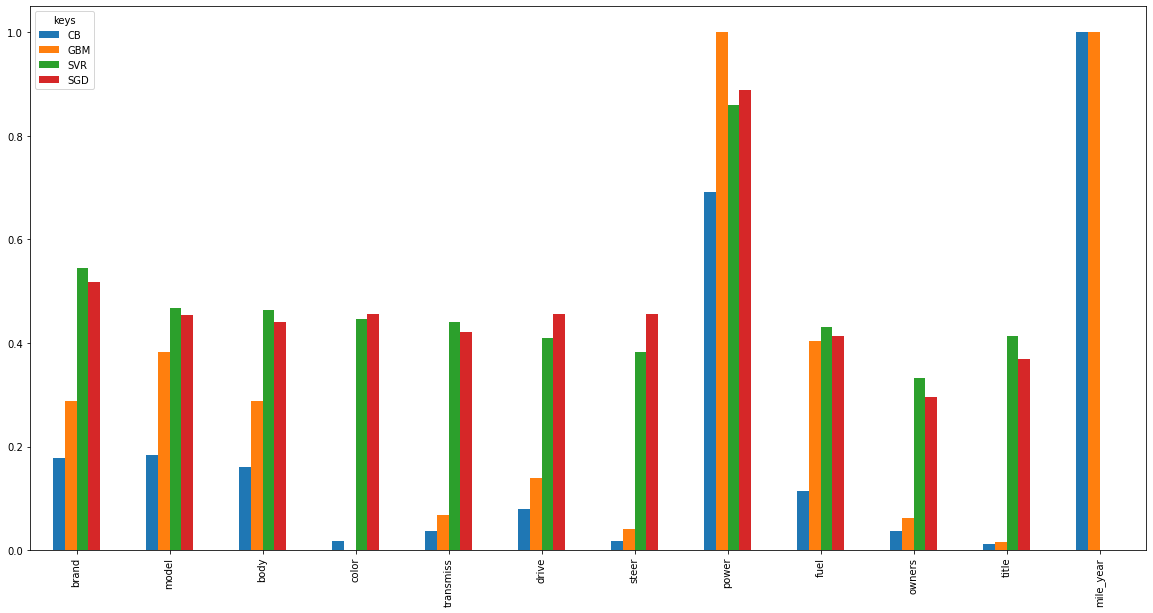

In [100]:
fi_for_plot=f_i_norm.transpose()
fi_for_plot.plot.bar(figsize=(20,10))

#
# Stacking with sklearn Stacking Regressor

In [34]:

estimators = [ ('cb',  CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          silent=True)                 ),
              ('lgb', lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=40)               ),
              ('svr', LinearSVR(random_state = RANDOM_SEED, 
                            C=1,
                            fit_intercept= True,
                            loss = 'squared_epsilon_insensitive',
                            max_iter = 500)              ),
              ('sgd', SGDRegressor( random_state= RANDOM_SEED,
                                   alpha=0.001,
                                   learning_rate='adaptive',
                                   loss='huber',
                                   penalty='elasticnet')  )   ]

st_reg = StackingRegressor(
          estimators=estimators,
          final_estimator=RandomForestRegressor(n_estimators=10,
                                                random_state=RANDOM_SEED)        )

st_reg.fit(X_tr, y_tr).score(X_valid, y_valid) # Returns the coefficient of determination Rsq of the prediction.



0.9419166503266652

In [35]:
y_pred=st_reg.predict(X_valid)
#оцениваем точность
print(f"Точность по метрике MAPE: {(mape(y_valid, y_pred))*100:0.2f}%")
st_reg = (mape(y_valid, y_pred))*100

Точность по метрике MAPE: 1.08%
